In [15]:
import numpy as np
import scipy.integrate
from scipy import optimize
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pygmo as pg
%matplotlib notebook

In [2]:
def u(x, u_max):
    ''' Control function
    
    Parameters
    ----------
    
    x : scalar
        Psi3 value.
        
    u_max : scalar 
            Maximum absolute control function value
            
    Returns
    ----------
    ux : scalar
         Control function value at given x with respect to u_max.
    '''
    
    ux = 0.0
    
    if x <= -1:
        ux = -u_max
    elif x > 1:
        ux = u_max
        
    return ux

In [3]:
def ode(t, x, args):
    ''' Right hand side of ODE
    
    Parameters
    ----------
    t : scalar
        Time.
        
    x : array_like with 5 components
        State vector.
        
    *args : array_like with 4 components
            args[0] - C1
            args[1] - C2
            args[2] - u_max
         
    Returns
    -------
    
    ds : np.array
        First order derivative
    '''
#     print(x)
#     print(args)
    x1, x2, x3, x4, x5 = x
    dx1dt = x2
    dx2dt = -args[0]*np.sin(2.0*x1)+args[1]*u(x3, args[2])
    dx3dt = -x4
    dx4dt = 2.0*args[0]*x3*np.cos(2.0*x1)
    dx5dt = -np.abs(u(x3, args[2]))
    
    dx = np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt])
    
    return dx

In [4]:
def stopNull(t, x, lst, **kwargs):
    ''' Dummy function for scipy.integrate.ode solout application. \
        Can be used for gathering all intergation steps.
        Shoudn't be called directly but through scipy.integrate.ode.
    
    Parameters
    ----------

    t : scalar
        Time.
        
    s : array_like with 6 components
        State vector.

    lst : list
        Every call of this function put np.hstack of (s, t) into lst. 
                      
    Returns
    -------
    
    0 : scalar
        Always. Will be treated by scipy.integrate.ode as it shouldn't
        stop integration process.
          
    '''
    lst.append(np.hstack((t,x)))
    return 0

In [5]:
def propOde(x0, tspan, C1, C2, u_max, **kwargs):
    ''' Propagate systwm of ode.
    Uses scipy.integrate.ode with 'dopri5' integrator.
    
    Parameters
    ----------
 
    x0 : array_like with 5 components
        Initial state vector.
        
    tspan : array_like with 2 components
        Initial and end time.
        
    C1 : scalar
         C1 parameter for ODE.
         
    C2 : scalar
         C2 parameter for ODE.
    
    u_max : scalar
            u_max parameter for ODE.
        
        
    Optional
    --------
    
    solout_func : function
                  Solout function for integrator.
        
    integrator : str
                 Name of the integrator.
        
    Returns
    -------
    
    Xt : np.array
      Array of (n,6) shape of state vectors and times
      for each integrator step (t, x1, x2, x3, x4, x5).
    '''
    #import pdb; pdb.set_trace()
    prop = scipy.integrate.ode(ode)
    if 'integrator' in kwargs:
        integrator = kwargs['integrator']
        prop.set_integrator(integrator)
    else:
        prop.set_integrator('dopri5')
        
    prop.set_initial_value(x0, tspan[0])
    
    prop.set_f_params([C1, C2, u_max])
    
    lst = []
    
    if 'solout_func' in kwargs:
        solout_func = kwargs['solout_func']
        prop.set_solout(solout_func)
    else:
        prop.set_solout(lambda t, s: stopNull(t, s, lst))
        
    prop.integrate(tspan[1])
    
    del prop
    
    return np.asarray(lst)

In [6]:
#U_max = 5
#C1 = 0.0430400628
#C2 = 1.0
# g = 12*1e4

In [7]:
def get_initial_state(x1T, x2T, g1 , g2):
    x1 = x1T
    x2 = x2T
    x3 = -2.0*g2*x2T
    x4 = -2.0*g1*x1T
    x5 = g1*x1T**2 + g2*x2T**2
    return np.array([x1, x2, x3, x4, x5])

In [8]:
#t0 0 
#T 10

In [9]:
s0 = get_initial_state(0.001, 0.0005, 12*1e4, 12*1e4)

In [10]:
s0

array([ 1.0e-03,  5.0e-04, -1.2e+02, -2.4e+02,  1.5e-01])

In [11]:
def create_arc(c,r,a1,a2,s):
    alpha = np.radians(np.linspace(a1,a2,s))
    x = r*np.cos(alpha) + c[0]
    y = r*np.sin(alpha) + c[1]
    
    return np.hstack((x.reshape(-1,1),y.reshape(-1,1)) )

In [12]:
stp = create_arc([0,0],0.001,0,360,30)

<IPython.core.display.Javascript object>


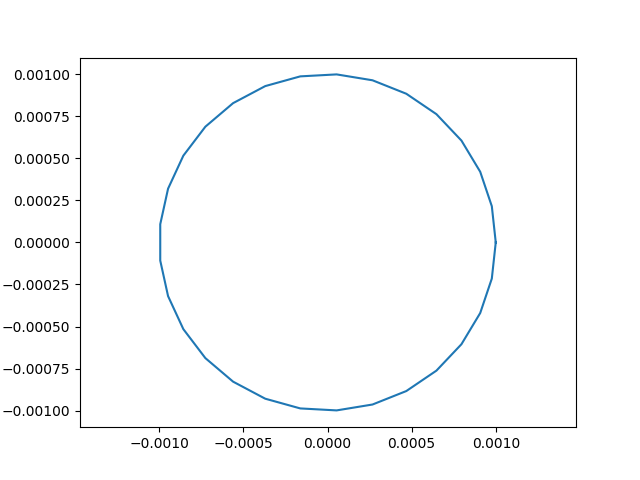

(-0.0010938448550120777,
 0.001099706897857718,
 -0.0010983867552362362,
 0.0010983867552362362)

In [13]:
plt.plot(stp[:,0],stp[:,1])
plt.axis('equal')

In [14]:
sols = []
for point in stp:
    s0 = get_initial_state(*point, 12*1e5, 12*1e5)
    sols.append(propOde(s0, [5.0, 0.0], C1=0.0430400628, C2=1.0, u_max=5.0))

<IPython.core.display.Javascript object>


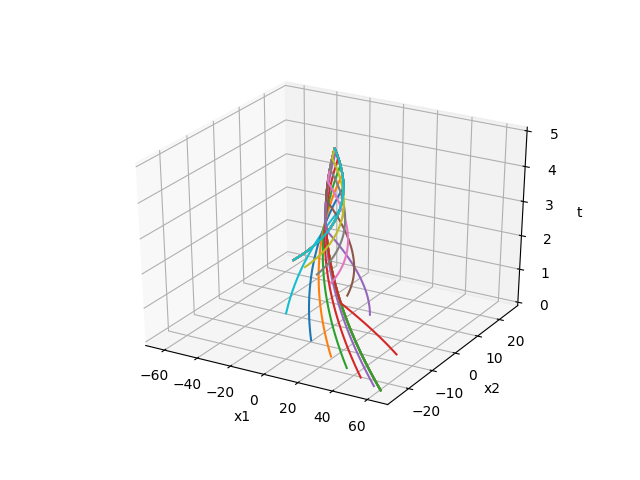

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for traject in sols:
    ax.plot(traject[:,1], traject[:,2], traject[:,0])
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('t')

In [16]:
def find_intersection(point, curv_coef):
    def func(x, args):
        c, a, b = args
        sign = np.sign(b)            
        return b*(x-a)/a + b - sign*c*np.cos(x)
    c = curv_coef
    a, b = point
    x1 = scipy.optimize.root_scalar(func, bracket=[-np.pi/2, np.pi/2], method='bisect', args=[c, a, b]).root
    x2 = b*(x1-a)/a + b
    return np.array([x1, x2])

In [17]:
temp_stp = create_arc([0.0, 0.0], 0.1, 0.0, 360.0, 30)
temp_int = np.array([find_intersection(point, 0.5) for point in temp_stp])

<IPython.core.display.Javascript object>


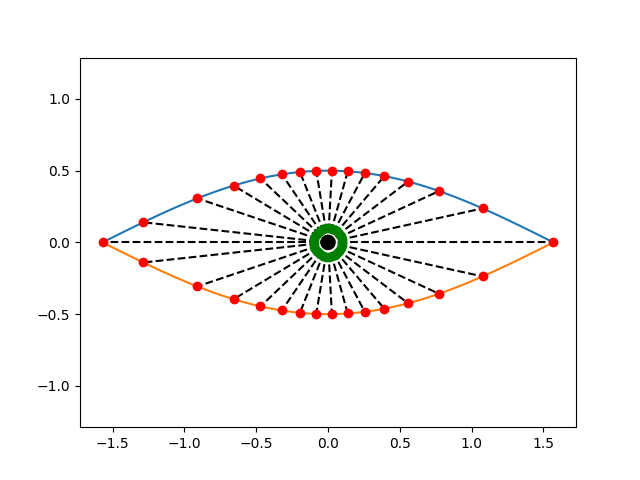

(-1.7278759594743862,
 1.7278759594743862,
 -0.5497980606473667,
 0.5497980606473685)

In [19]:
c1=0.5
xspan = np.linspace(-np.pi/2, np.pi/2)
plt.plot(xspan, c1*np.cos(xspan))
plt.plot(xspan, -c1*np.cos(xspan))
for point, int_p in zip(temp_stp, temp_int):
    plt.plot([0.0, int_p[0]], [0.0, int_p[1]], 'k--')
    plt.plot(*point, 'go')
    plt.plot(*int_p, 'ro')
plt.axis('equal')

In [23]:
class measure:
    def __init__(self, C):
        self.C = C

    def evaluate(self, points):
        #C1 = 0.5 # ВСТАВИТЬ РЕАЛЬНОЕ ЗНАЧЕНИЕ
        borders_check = np.abs(points[:,1]) < self.C*np.abs(np.cos(points[:,0])) # Продумать отступ
        if False in borders_check:
            return 1e16

        intersections = np.array([find_intersection(point, self.C) for point in points])
        sum_norm = np.linalg.norm( intersections - points, axis=1).sum()
        return sum_norm

In [24]:
mes = measure(0.5)

In [25]:
mes.evaluate(np.array([[0.1,0.1]]))

0.49523441241535593

In [64]:
class cons_control_udp:
    def __init__(self, measure, eps):
        self.eps = eps
        self.measure = measure
    def fitness(self, x):
        s0 = get_initial_state(*x, 12*1e5, 12*1e5)
        end_points = propOde(s0, [5.0, 0.0], C1=0.0430400628, C2=1.0, u_max=5.0)[-1][1:3]
        obj = self.measure.evaluate(np.array([end_points]))
        ci = x[0]**2 + x[1]**2 - self.eps
        return [obj, ci]
    def get_bounds(self):
        return ([-np.pi/2, -self.measure.C], [np.pi/2, self.measure.C])
    def get_nic(self):
        return 1
    def get_nec(self):
        return 0
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x),x)

In [65]:
prob = pg.problem(cons_control_udp(measure=mes, eps=0.001))

In [66]:
print(prob)

Problem name: <class '__main__.cons_control_udp'>
	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			2
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	1
	Tolerances on constraints: [0]
	Lower bounds: [-1.5708, -0.5]
	Upper bounds: [1.5708, 0.5]

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 4
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [97]:
# algo = pg.algorithm(uda = pg.nlopt('auglag'))
# algo.extract(pg.nlopt).local_optimizer = pg.nlopt('var2')
# algo.set_verbosity(200)

In [118]:
algo = pg.algorithm(pg.pso(gen=500))

In [119]:
pop = pg.population(prob=cons_control_udp(measure=mes, eps=0.001), size=10)

In [120]:
pop = algo.evolve(pop)

ValueError: 
function: evolve
where: /home/alex/anaconda3/include/pagmo/algorithms/pso.hpp, 233
what: Non linear constraints detected in <class '__main__.cons_control_udp'> instance. PSO: Particle Swarm Optimization cannot deal with them


In [110]:
pop

Problem name: <class '__main__.cons_control_udp'>
	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			2
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	1
	Tolerances on constraints: [1e-06]
	Lower bounds: [-1.5708, -0.5]
	Upper bounds: [1.5708, 0.5]

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 4
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 61
	Gradient evaluations: 48

	Thread safety: none

Population size: 10

List of individuals: 
#0:
	ID:			11526109276206293997
	Decision vector:	[-0.52085, -0.190664]
	Fitness vector:		[1e+16, 0.306637]
#1:
	ID:			16967077237734541669
	Decision vector:	[-0.811785, 0.201805]
	Fitness vector:		[1e+16, 0.69872]
#2:
	ID:			8951367027981804791
	Decision vector:	[-0.692863, 0.380885]
	Fitness vector:		[1e+16, 0.624133]
#3:
	ID:			3484679148643233680
	Decision vector:	[-1.39578, 0.447329]
	Fitness vector:		[1e+

In [92]:
pop.get_x()

array([[-0.02552032, -0.00630934]])

In [75]:
eps_arc = create_arc([0.0,0.0], 0.001, 0, 360, 30)

<IPython.core.display.Javascript object>


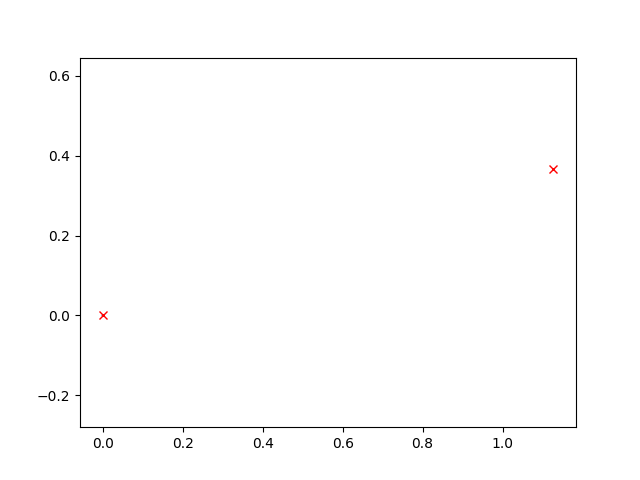

(-0.05741866019846682,
 1.1839208291104073,
 -0.019373444573986577,
 0.3848746009489934)

In [78]:
plt.plot(eps_arc[:,0], eps_arc[:,1])
plt.plot(pop.get_x()[:,0], pop.get_x()[:,1], 'rx')
plt.axis('equal')

In [82]:
s01 = get_initial_state(5.0085e-11, -2.67767e-12, 12*1e5, 12*1e5)
sol1 =propOde(s01, [5.0, 0.0], C1=0.0430400628, C2=1.0, u_max=5.0)[-1][1:3]

In [83]:
sol1

array([1.42681440e-11, 1.43380014e-11])

In [84]:
mes.evaluate(np.array([sol1]))

0.6356592695625927